<a href="https://colab.research.google.com/github/avnishcodes/StockPriceForecasting/blob/main/StockPriceForecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
import pandas as pd
url = "https://raw.githubusercontent.com/avnishcodes/StockPriceForecasting/refs/heads/main/yahoo_stock.csv"
df = pd.read_csv(url)
df.head()

,Date,High,Low,Open,Close,Volume,Adj Close
0,2015-11-23,2095.610107,2081.389893,2089.409912,2086.590088,3.587980e+09,2086.590088
1,2015-11-24,2094.120117,2070.290039,2084.419922,2089.139893,3.884930e+09,2089.139893
2,2015-11-25,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
3,2015-11-26,2093.000000,2086.300049,2089.300049,2088.870117,2.852940e+09,2088.870117
4,2015-11-27,2093.290039,2084.129883,2088.820068,2090.110107,1.466840e+09,2090.110107


In [18]:
df.columns

Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')

In [19]:
df.isnull().sum()

,0
Date,0
High,0
Low,0
Open,0
Close,0
Volume,0
Adj Close,0


In [20]:
#sort by date if not already sorted
df = df.sort_index()
#Create lag feature (previous day's Close price)
df['Close_lag1'] = df['Close'].shift(1)
#Drop missing rows caused by shift
df = df.dropna()

In [21]:
X = df[['Close_lag1']]
y = df['Close']


In [22]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2  # Important: no shuffle for time series
)


In [23]:
from sklearn.ensemble import RandomForestRegressor
# Initialize the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
# Train the model
model.fit(X_train, y_train)
# Predict on test data
y_pred = model.predict(X_test)


In [24]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# Define hyperparameter distribution
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': randint(5, 30),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 10)
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=param_dist,
    n_iter=10,                # Try 10 combinations
    cv=3,                     # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=1,
    random_state=42,
    n_jobs=-1                 # Use all available cores
)

# Fit the tuning on training data
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_
print("Best Parameters:\n", random_search.best_params_)

# Predict with best model
y_pred = best_model.predict(X_test)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
Best Parameters:
 {'max_depth': 14, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 104}


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
# Evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # Manually calculate RMSE
r2 = r2_score(y_test, y_pred)
# Print results
print("MAE:", mae)
print("RMSE:", rmse)
print("R² Score:", r2)


MAE: 150.126149725774
RMSE: 196.65166118989234
R² Score: 0.4790890385176737


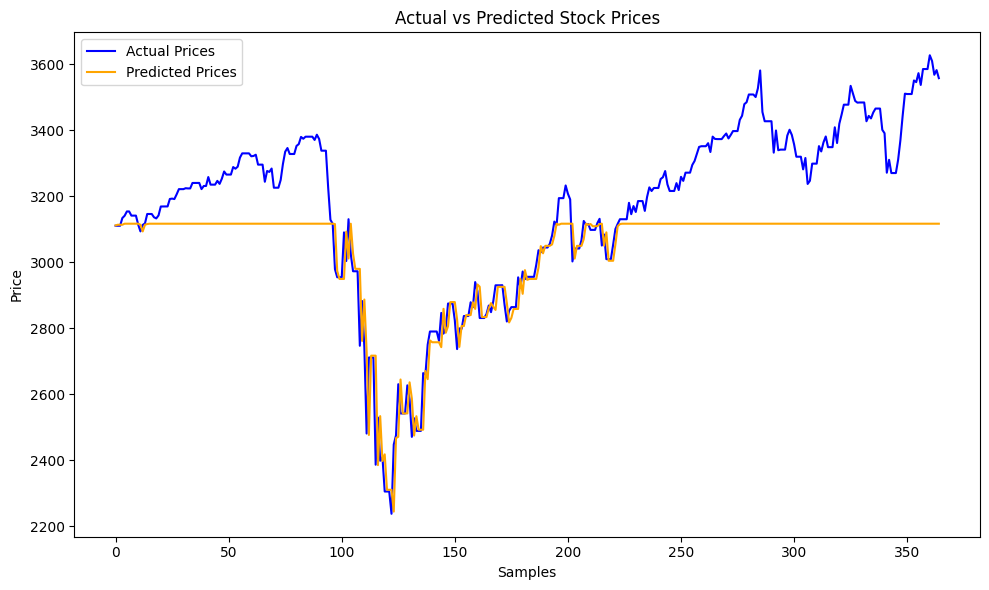

In [26]:
import matplotlib.pyplot as plt
# Plot actual vs predicted
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='orange')
plt.title("Actual vs Predicted Stock Prices")
plt.xlabel("Samples")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()


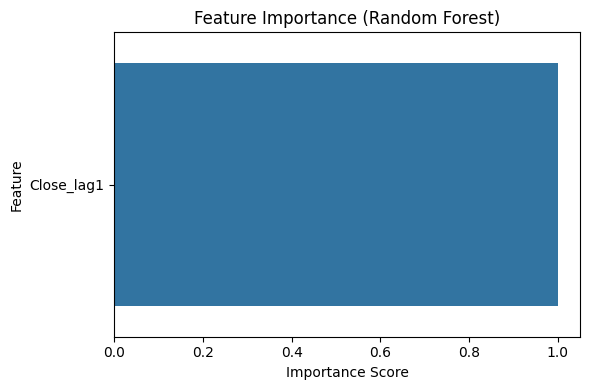

In [27]:
# Show feature importance
import seaborn as sns
import matplotlib.pyplot as plt
# Get feature importances
importances = best_model.feature_importances_
features = X.columns  # Only 'Close_lag1' in your case
feat_imp = pd.Series(importances, index=features)
# Plot the feature importance
plt.figure(figsize=(6, 4))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
